In [1]:
import numpy as np
import torch

(10000, 40)


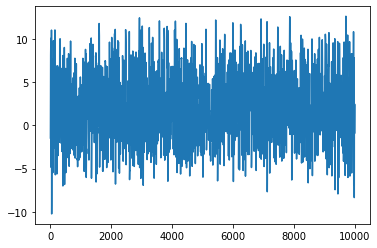

In [2]:
from scipy.integrate import solve_ivp

def Lorenz_96(S,t,F,J):
    """ Lorenz-96 dynamical model. """
    x = np.zeros(J);
    x[0] = (S[1]-S[J-2])*S[J-1]-S[0];
    x[1] = (S[2]-S[J-1])*S[0]-S[1];
    x[J-1] = (S[0]-S[J-3])*S[J-2]-S[J-1];
    for j in range(2,J-1):
        x[j] = (S[j+1]-S[j-2])*S[j-1]-S[j];
    dS = x.T + F;
    return dS

dt_int  = 0.05
len_int = 10000#40000

x0 = 40 * np.ones(40);
x0[np.int(np.around(20))] = x0[np.int(np.around(20))] + 0.01
S = solve_ivp(fun=lambda t,y: Lorenz_96(y, t, 8, 40), 
              t_span=[0.,10+0.000001], y0=x0, first_step=dt_int, t_eval=np.arange(0, 5+0.000001, dt_int), method='RK45')

x0 = S.y[:,-1]
tt = np.arange(dt_int, len_int*dt_int+0.000001, dt_int)
S = solve_ivp(fun=lambda t,y: Lorenz_96(y, t, 8, 40), 
              t_span=[dt_int, len_int*dt_int+0.000001], y0=x0, first_step=dt_int, t_eval=tt, method='RK45')
S = S.y.transpose()

import matplotlib.pyplot as plt 

print(S.shape)
plt.plot(S[:10000, 0])

In [3]:
from sklearn.feature_extraction import image

ratio    = 4
sigNoise = 1.414

# extract subsequences
dataTestNoNaN      = image.extract_patches_2d(S, (200, 40), 2000)

dataTest         = np.zeros((dataTestNoNaN.shape))
dataTest[:]      = float('nan')

for ii in range(0, dataTest.shape[1], ratio):
    indrand = np.random.permutation(dataTest.shape[2])[0:int(0.5*dataTest.shape[2])]
    dataTest[:, ii, indrand] = dataTestNoNaN[:, ii, indrand]
    
maskTest  = ( dataTest     ==  dataTest    ).astype('float')

dataTest  = np.nan_to_num(dataTest)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

X_test          = dataTestNoNaN
X_test_missing  = dataTest
mask_test       = maskTest

## normalized data
meanTr          = 2.3678771
stdTr           = 4.35246785

x_test_missing  = (X_test_missing - meanTr) / stdTr
x_test   = (X_test - meanTr) / stdTr
X_test_obs   = X_test_missing   + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0], X_test_missing.shape[1], X_test_missing.shape[2])

x_test_obs   = (X_test_obs - meanTr) / stdTr

/software/python/virtualenv/py3.6-gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass max_patches=2000 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [4]:
from sklearn import decomposition
import scipy

def interp(x, masks):
    x_init = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2]))
    for ii in range(0, x.shape[0]):
        # Initial linear interpolation for each component
        XInit = np.zeros((masks.shape[1], masks.shape[2]))

        for kk in range(0, 40):
            indt  = np.where( masks[ii, kk, :] == 1.0 )[0]
            indt_ = np.where( masks[ii, kk, :] == 0.0 )[0]
            if len(indt) > 1:
                indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
                indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
                fkk = scipy.interpolate.interp1d(indt, x[ii, kk, indt])
                XInit[kk, indt]  = x[ii, kk, indt]
                XInit[kk, indt_] = fkk(indt_)
            else:
                XInit = XInit + meanTr

        x_init[ii,:,:] = XInit

    return x_init

In [5]:
x_test_init     =  interp(x_test_obs, mask_test)

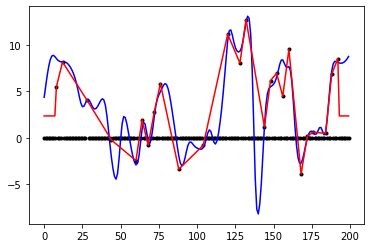

In [6]:
import matplotlib.pyplot as plt 
idx = 12
jj = 1
# Visualisation
plt.plot(X_test_obs[idx,jj,:], 'k.')
plt.plot(X_test[idx,jj,:],'b-')
plt.plot(x_test_init[idx,jj,:] * stdTr + meanTr,'r-')

In [ ]:
np.savez('testset_2', x_test_obs=x_test_obs, x_test=x_test, 
         x_test_init=x_test_init, mask_test=mask_test, std=stdTr, mean=meanTr)